# Restricted Boltzmann Machine as a Generative Model
The following code is partly referenced from
https://github.com/odie2630463/Restricted-Boltzmann-Machines-in-pytorch
## Setup PyTorch

In [1]:
from __future__ import division
try:
    import torch
except:
    !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
    !pip install torchvision
    import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

### make sure we are using GPU (Nvidia K80)

In [2]:
has_cuda = torch.cuda.is_available()
if not has_cuda:
    print('Not Using CUDA!')
else:
    print('Using CUDA device %d!'%torch.cuda.current_device())
    ts = torch.Tensor([1,2,3])
    ts = ts.cuda()
    # you will see the location information of a tensor by printing it out.
    print(ts)

Using CUDA device 0!

 1
 2
 3
[torch.cuda.FloatTensor of size 3 (GPU 0)]



## Code an RBM
#### Derivative of Negative log-likelihood
$\frac{\partial{\mathcal{L}}}{\partial \theta}=\langle \frac{\partial E_\theta(x)}{\partial \theta}\rangle_{x\sim\mathcal{D}}-\langle \frac{\partial E_\theta(x)}{\partial \theta}\rangle_{x\sim p_{\theta}(x)}$

#### Free energy
$E_\theta(v) = -\log(p_\theta(x))$

#### $k$-th order Contractive divergence (CD-$k$)
Foward Gibbs sampling $x_0\rightarrow h_0$ + backward Gibbs sampling $h_0\rightarrow x_1$ + $\ldots$ + backward Gibbs sampling $h_{k-1}\rightarrow x_k$.

For $k=\infty$, we will get exact $p_{\rm \theta}(x)$.

In [3]:
class RBM(nn.Module):
    '''
    Restricted Boltzmann Machine

    Args:
        num_visible (int): number of visible nodes.
        num_hidden (int): number of hidden nodes.

    Attributes:
        W (2darray): weights.
        v_bias (1darray): bias for visible layer.
        h_bias (1darray): bias for hidden layer.
    '''

    def __init__(self, num_visible, num_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(num_hidden, num_visible) * 1e-2)
        self.v_bias = nn.Parameter(torch.zeros(num_visible))
        self.h_bias = nn.Parameter(torch.randn(num_hidden) * 1e-2)
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def _v_to_h(self, v):
        '''
        forward pass p(h|v) from visible to hidden, v is visible input.
        '''
        p_h = F.sigmoid(F.linear(v, self.W, self.h_bias))
        return p_h

    def _h_to_v(self, h):
        '''
        backward pass p(v|h) from hidden to visible, h is hidden input.
        '''
        p_v = F.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return p_v

    def contrastive_divergence(self, v, k):
        '''
        Args:
            v (ndarray): visible input.
            k (in): CD-k, means k times v->h & h->v sweep in a single contrastive divergence run.

        Returns:
            ndarray: visible obtained through CD sampling.
        '''
        prob_h = self._v_to_h(v)
        h = sample_from_prob(prob_h)
        for _ in range(k):
            prob_v = self._h_to_v(h)
            v = sample_from_prob(prob_v)
            prob_h = self._v_to_h(v)
            h = sample_from_prob(prob_h)
        return v

    def free_energy(self, v):
        '''
        free energy E(x) = -log(\sum_h exp(x, h)) = -log(p(x)*Z).
        It can be used to obtain negative log-likelihood L = <E(x)>_{data} - <E(x)>_{model}.

        Args:
            v (1darray,2darray): visible input with size ([batch_size, ]data_size).

        Return:
            float: the free energy loss.
        '''
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v, self.W, self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(dim=-1)
        return (-hidden_term - vbias_term).mean()

In [4]:
def sample_from_prob(prob_list):
    '''
    from probability to 0-1 sample.

    Args:
        prob_list (1darray): probability of being 1.

    Returns:
        1darray: 0-1 array.
    '''
    rand = Variable(torch.rand(prob_list.size()))
    if prob_list.is_cuda:
        rand = rand.cuda()
    return (1+torch.sign(prob_list - rand))/2.


## Load Dataset

In [5]:
def mnist01_loader(is_train, use_cuda, batch_size):
    '''
    yield image and label from mnist dataset.

    Args:
        is_train (bool): yield traning set if True, else test set.
        use_cuda (bool): return data on GPU in True.
        batch_size (int): size of a batch.

    Returns:
        func: an iterator function.
    '''
    from torchvision import datasets, transforms
    import torch.utils.data
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=is_train,
                    download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ])), batch_size=batch_size)

    def iterator():
        for data, label in test_loader:
            # transform to binary mnist image
            data = Variable(data.view(-1, 784))
            data = data.bernoulli()
            if use_cuda:
                # copy data to gpu memory
                data = data.cuda()
                label = label.cuda()
            yield data, label
    return iterator

torch.Size([64, 784]) torch.Size([64])
A hand written digit with label "5"


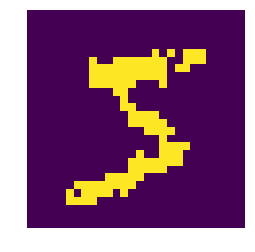

In [ ]:
import matplotlib.pyplot as plt
loader = mnist01_loader(is_train=True, use_cuda=False, batch_size=64)
# let's check the data and labels
for data, label in loader():
    print(data.shape, label.shape)
    print('A hand written digit with label "%d"'%label[0])
    plt.imshow(data[0].data.numpy().reshape([28, 28]))
    plt.axis('off')
    plt.show()
    break

## Use RBM as a Generative Model

In [ ]:
import time

use_cuda = True   # if you don't have cuda, this line must be set False!
num_visible = 784
num_hidden = 500

# set seed for pytorch-cpu, pytorch-gpu and numpy
seed = 10086
torch.manual_seed(seed)
if use_cuda: torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# define network and dataset, and transfer model data into GPU memory
rbm = RBM(num_visible, num_hidden)
if use_cuda: rbm = rbm.cuda()
loader = mnist01_loader(True, use_cuda, batch_size=64)

# with the stochastic gradient descent optimizer,
# we optimize model parameters with learning rate 0.1.
train_op = torch.optim.SGD(rbm.parameters(), 0.1)
for epoch in range(20):
    t0 = time.time()
    loss_list = []
    for data, label in loader():
        # calculate the "loss", the last node in computation graph
        v1 = rbm.contrastive_divergence(data, k=1)
        loss = rbm.free_energy(data) - rbm.free_energy(v1)
        loss_list.append(loss.data[0])

        # get gradients using back propagation.
        # zero_grad are needed before backward, otherwise gradients are accumulated.
        train_op.zero_grad()
        loss.backward()
        # update parameters using gradients using gradients.
        train_op.step()
    t1 = time.time()
    print('epoch %d, Mean "Loss" = %.4f, Elapse = %.4f'%(epoch, np.mean(loss_list), t1-t0))

epoch 0, Mean "Loss" = -8.4216, Elapse = 11.7406
epoch 1, Mean "Loss" = -6.7213, Elapse = 14.5283
epoch 2, Mean "Loss" = -4.6605, Elapse = 15.8155
epoch 3, Mean "Loss" = -3.2209, Elapse = 15.9363
epoch 4, Mean "Loss" = -2.1977, Elapse = 14.9851
epoch 5, Mean "Loss" = -1.5967, Elapse = 16.2703
epoch 6, Mean "Loss" = -1.1086, Elapse = 12.6944
epoch 7, Mean "Loss" = -0.7555, Elapse = 13.4350
epoch 8, Mean "Loss" = -0.4712, Elapse = 12.4645
epoch 9, Mean "Loss" = -0.2805, Elapse = 11.9286
epoch 10, Mean "Loss" = -0.1029, Elapse = 10.4068
epoch 11, Mean "Loss" = 0.0530, Elapse = 12.2573
epoch 12, Mean "Loss" = 0.2131, Elapse = 12.2388
epoch 13, Mean "Loss" = 0.2278, Elapse = 12.0158
epoch 14, Mean "Loss" = 0.2971, Elapse = 11.8999
epoch 15, Mean "Loss" = 0.3948, Elapse = 10.4259
epoch 16, Mean "Loss" = 0.4169, Elapse = 10.1953
epoch 17, Mean "Loss" = 0.5284, Elapse = 10.8730


In [ ]:
%matplotlib inline
from torchvision.utils import make_grid

# check for CD-1 generated data, they are similar to original data
data, label = next(mnist01_loader(False, use_cuda, batch_size=32)())
generated = rbm.contrastive_divergence(data, k=1)

gs = plt.GridSpec(2,1)
for irow, img in [(0, data), (1, generated)]:
    img_grid = make_grid(img.view(32, 1, 28, 28).data)
    npimg = np.transpose(img_grid.cpu().numpy(), (1, 2, 0))

    plt.subplot(gs[irow,0])
    plt.imshow(npimg)
    plt.axis('off')
plt.show()

## Quiz
* Try to explain why the loss goes up.
* How much ($t_{\rm CPU}/t_{\rm GPU}$) a GPU can accelerate in this case?
* Try CD-10 training, and CD-10 reconstruction, tell the difference.

## Challenge
To see how RBM can be useful, try to solve the following problem.

Top half of an image is lost, the only knowlege we know is it is a hand written number, try to recover this image.

This image is:

In [ ]:
# presented data, npdata[:14] is replace by noises, with rest the correct values.
npdata = np.array([0.87207395, 0.30172917, 0.20748128, 0.8095541, 0.6876969, 0.1532767, 0.62968737, 0.7779726, 0.7118719, 0.53654927, 0.94739664, 0.4471923, 0.8174037, 0.99884754, 0.88779926, 0.71121424, 0.3754819, 0.8892206, 0.6074483, 0.80546534, 0.86275977, 0.59773445, 0.8402653, 0.86507905, 0.42217958, 0.87019306, 0.7207597, 0.70173293, 0.5013676, 0.632447, 0.7610868, 0.9116219, 0.27281326, 0.5140466, 0.85905105, 0.6330603, 0.7861834, 0.48230517, 0.5583505, 0.46642596, 0.9083495, 0.5351944, 0.1025035, 0.098153934, 0.5750544, 0.16645348, 0.16748504, 0.88547695, 0.43294504, 0.6214652, 0.71871835, 0.091364935, 0.93197143, 0.18161148, 0.34041223, 0.36640248, 0.05945792, 0.84343576, 0.05011359, 0.020642783, 0.96630734, 0.02089095, 0.8930233, 0.3763136, 0.9165772, 0.97183466, 0.63145226, 0.9990819, 0.009387237, 0.50575066, 0.64946336, 0.35694385, 0.69572824, 0.9233393, 0.86297685, 0.95064604, 0.5617286, 0.20560175, 0.7403321, 0.27093577, 0.97413605, 0.26959816, 0.87772864, 0.044952888, 0.102199115, 0.9718467, 0.16127962, 0.655842, 0.15577097, 0.019478982, 0.79594487, 0.5539078, 0.23640345, 0.9437329, 0.9587844, 0.17794718, 0.6766039, 0.8290011, 0.4769842, 0.4305203, 0.8977303, 0.6218739, 0.7924648, 0.76474386, 0.3790167, 0.77901715, 0.14843856, 0.49938354, 0.0016661843, 0.53694785, 0.28133965, 0.50130546, 0.7144231, 0.21561551, 0.71205837, 0.22371855, 0.87220854, 0.26955116, 0.23340793, 0.35401136, 0.8505834, 0.3398249, 0.5540171, 0.10345899, 0.42512947, 0.038393788, 0.14067493, 0.35083002, 0.78112274, 0.7566516, 0.7144876, 0.85403043, 0.17873417, 0.35017425, 0.8706891, 0.9905999, 0.03664582, 0.21388373, 0.19397263, 0.49474058, 0.45710087, 0.5013515, 0.45443046, 0.49812528, 0.20585743, 0.6777932, 0.52848434, 0.24695043, 0.05329345, 0.8382803, 0.7743761, 0.75724375, 0.47649342, 0.3232994, 0.97870475, 0.95442826, 0.8724979, 0.7017745, 0.31166396, 0.86247295, 0.19751902, 0.7225639, 0.66581416, 0.053260047, 0.91416854, 0.5880709, 0.97473216, 0.11180539, 0.19542904, 0.6878177, 0.77867174, 0.6552874, 0.15082805, 0.036130577, 0.40634972, 0.92630273, 0.20962614, 0.34388322, 0.37616885, 0.15954784, 0.06997797, 0.53446907, 0.2530169, 0.15803383, 0.79036176, 0.84305835, 0.54108804, 0.8501002, 0.8879858, 0.75407153, 0.42112336, 0.9809118, 0.38506842, 0.70881325, 0.9115492, 0.98289156, 0.29546624, 0.5558135, 0.73718935, 0.4230012, 0.6937958, 0.16916722, 0.08621408, 0.6282674, 0.78306913, 0.032396235, 0.05875099, 0.08453581, 0.7941298, 0.44791576, 0.49781203, 0.24143413, 0.6512627, 0.20860681, 0.697907, 0.7528845, 0.372322, 0.7488793, 0.27171475, 0.72370976, 0.69339174, 0.8918535, 0.5999, 0.30938724, 0.3181647, 0.64025414, 0.78654414, 0.47598284, 0.8310249, 0.11720193, 0.2878025, 0.52041465, 0.9025964, 0.28781494, 0.8044487, 0.3056101, 0.33250284, 0.92022175, 0.286686, 0.9976094, 0.9832922, 0.31882682, 0.55324644, 0.43472946, 0.5232928, 0.54625267, 0.3906454, 0.62188476, 0.27731606, 0.16046757, 0.5718505, 0.35741845, 0.19788711, 0.6796674, 0.23651811, 0.08174702, 0.06336878, 0.09723609, 0.6873774, 0.14071466, 0.10673229, 0.72016853, 0.14792068, 0.6807766, 0.65582806, 0.30159968, 0.033888057, 0.9616834, 0.71672386, 0.7785365, 0.93777555, 0.4879574, 0.6355177, 0.5111196, 0.3009759, 0.3500596, 0.74764377, 0.13936538, 0.7483063, 0.81750077, 0.022937937, 0.4070562, 0.31818643, 0.5540159, 0.92213124, 0.73755354, 0.5571023, 0.75489575, 0.67721623, 0.72045094, 0.9948514, 0.70227563, 0.4672006, 0.106317885, 0.9804078, 0.6265774, 0.5751128, 0.6412867, 0.7626526, 0.63349885, 0.6859269, 0.42727026, 0.87387127, 0.30769062, 0.21811083, 0.7262418, 0.3143378, 0.5617967, 0.52690506, 0.5614177, 0.2285414, 0.85394025, 0.4490645, 0.3991946, 0.4290848, 0.260644, 0.45061842, 0.79720527, 0.8023241, 0.8577737, 0.15940316, 0.28310093, 0.5588658, 0.40793347, 0.3871484, 0.19407174, 0.090147026, 0.3032796, 0.56522983, 0.31781578, 0.9819852, 0.27190876, 0.27358428, 0.08329663, 0.9401394, 0.64813715, 0.43394515, 0.20502856, 0.6062421, 0.77016854, 0.6724567, 0.05586233, 0.30247933, 0.6605889, 0.59062487, 0.07923536, 0.79024094, 0.7947558, 0.47801945, 0.7789812, 0.7338063, 0.81782705, 0.86098266, 0.37724164, 0.025790595, 0.13603827, 0.70920366, 0.39994055, 0.9000277, 0.24124062, 0.556982, 0.9389691, 0.19500403, 0.0904483, 0.9657381, 0.36499324, 0.53046125, 0.7467004, 0.558991, 0.70214766, 0.047792256, 0.8731797, 0.6984725, 0.6879274, 0.28380287, 0.5657824, 0.82289946, 0.628091, 0.8842273, 0.6312523, 0.86718184, 0.046136532, 0.89170617, 0.27153188, 0.12342716, 0.4058729, 0.21863484, 0.7674653, 0.026953213, 0.44575384, 0.20404944, 0.8207133, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype='float32').reshape([28, 28])
plt.imshow(npdata)
plt.axis('off')
plt.show()

Here, I will give you some **hint**.

* Train a better RBM to complete this task.

* Make this image a initial input, and perform Gibbs sampling sounds a good idea. Try to write a modified version of **contrastive_divergence** method.
* data transform related API (pytorch API page: http://pytorch.org/docs/0.3.0/): 

```python
    torch.from_numpy
    torch.Tensor.numpy
    torch.Tensor.cuda
    torch.Tensor.cpu
    torch.autograd.Variable
```